In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
import torch
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc

In [4]:
# Define paths based on your directory structure
main_dir = "/Users/chiragchivate/Documents/Northeastern/SML/project/MRNet-v1.0"
train_path = os.path.join(main_dir, "train")
valid_path = os.path.join(main_dir, "valid")

Axial scan shape: (44, 256, 256)
Coronal scan shape: (36, 256, 256)
Sagittal scan shape: (36, 256, 256)


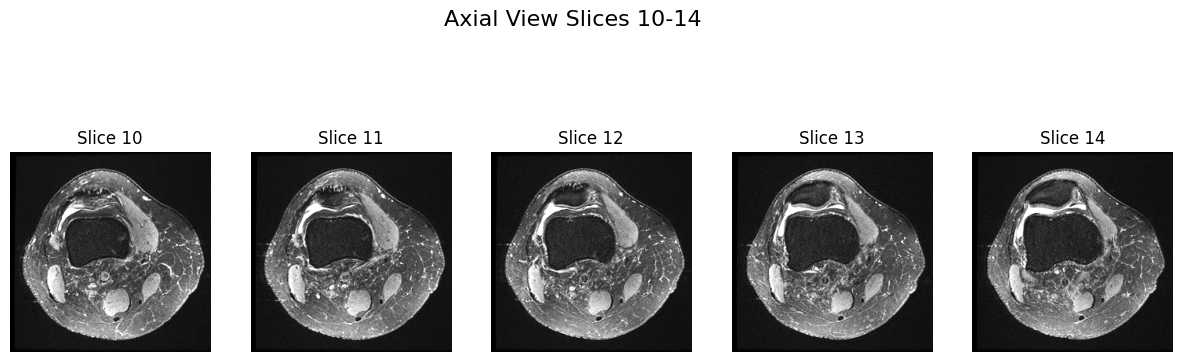

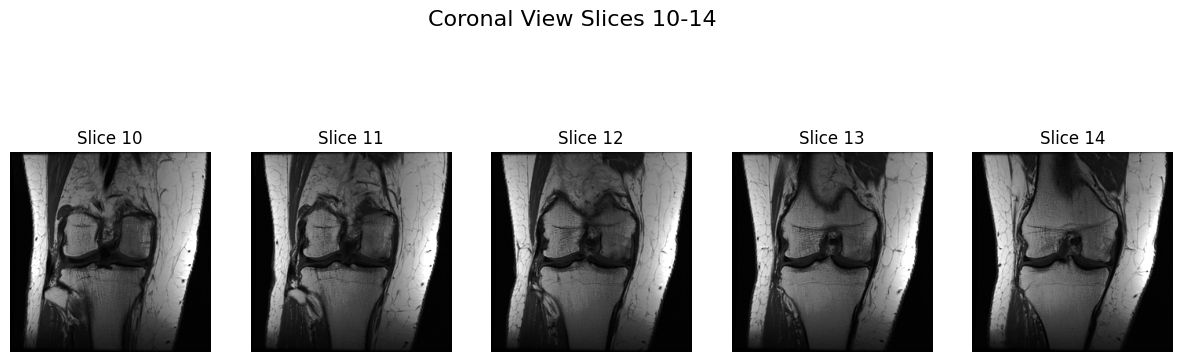

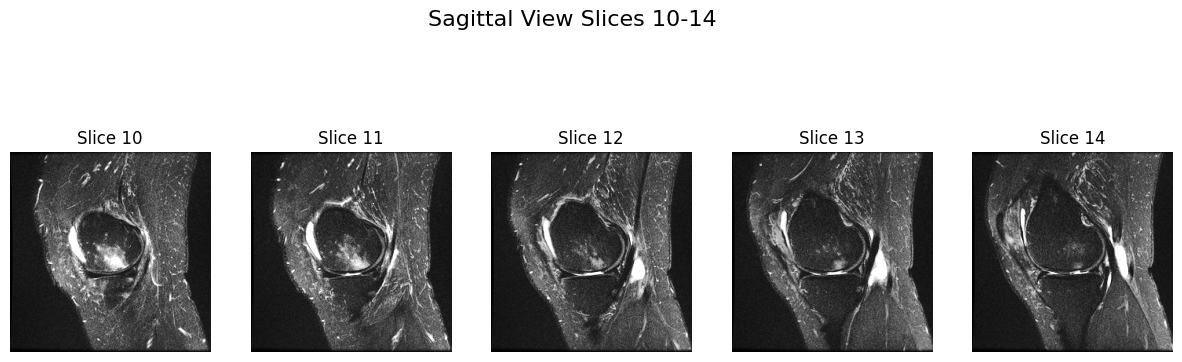

In [3]:
# Define paths to the .npy files for each axis
base_dir = "/Users/chiragchivate/Documents/Northeastern/SML/project/MRNet-v1.0/train"
file_id = "0000"  # Change this to the desired file number

axial_path = f"{base_dir}/axial/{file_id}.npy"
coronal_path = f"{base_dir}/coronal/{file_id}.npy"
sagittal_path = f"{base_dir}/sagittal/{file_id}.npy"

# Load MRI scans from the .npy files
axial_scan = np.load(axial_path)
coronal_scan = np.load(coronal_path)
sagittal_scan = np.load(sagittal_path)

# Check the shape of each MRI scan
print("Axial scan shape:", axial_scan.shape)
print("Coronal scan shape:", coronal_scan.shape)
print("Sagittal scan shape:", sagittal_scan.shape)

# Function to visualize slices for each view
def visualize_mri_slices(mri_scan, start_slice=10, end_slice=20, view=""):
    """
    Visualize a range of slices from a 3D MRI scan.
    
    Parameters:
    - mri_scan: 3D numpy array (depth, height, width).
    - start_slice: Starting slice index.
    - end_slice: Ending slice index.
    - view: Name of the view (axial, coronal, sagittal) for the title.
    """
    num_slices = end_slice - start_slice
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    fig.suptitle(f"{view.capitalize()} View Slices {start_slice}-{end_slice-1}", fontsize=16)
    
    for i in range(num_slices):
        slice_index = start_slice + i
        axes[i].imshow(mri_scan[slice_index], cmap="gray")
        axes[i].set_title(f"Slice {slice_index}")
        axes[i].axis("off")

    plt.show()

# Visualize slices 10 to 15 for each view
visualize_mri_slices(axial_scan, start_slice=10, end_slice=15, view="axial")
visualize_mri_slices(coronal_scan, start_slice=10, end_slice=15, view="coronal")
visualize_mri_slices(sagittal_scan, start_slice=10, end_slice=15, view="sagittal")


This code displays a series of MRI slices (images) from a knee MRI scan along three different anatomical planes: **axial**, **coronal**, and **sagittal**. Here’s a breakdown of what each part of the output represents:

### MRI Planes Explained

1. **Axial View**:
   - This view shows cross-sectional slices of the knee from the top down.
   - The displayed slices (10 to 15) reveal horizontal sections at different depths.
   - This perspective helps visualize structures from a top-down viewpoint, allowing insight into the internal anatomy layer by layer.

2. **Coronal View**:
   - This view provides a frontal cross-section of the knee, as if looking straight at it.
   - Slices 10 to 15 in this view reveal sections progressing from the front to the back of the knee.
   - This view is particularly useful for seeing the alignment of structures like the meniscus and ACL within the frontal plane.

3. **Sagittal View**:
   - The sagittal plane divides the knee from left to right.
   - Slices 10 to 15 show vertical slices through the knee, moving from one side to the other.
   - The sagittal view is beneficial for assessing structures that span from the front to the back of the knee, such as the ACL.

### Visual Output

- **Layout**: Each set of slices is displayed in a row, with the title indicating the anatomical plane.
- **Interpretation**:
  - Axial, coronal, and sagittal images highlight different anatomical perspectives.
  - By viewing slices 10 to 15 in each plane, one can examine the knee’s structural continuity and identify any abnormalities across multiple views.

These combined views give a comprehensive perspective of the knee, helping in understanding its structure and identifying potential issues.


Animation saved as /Users/chiragchivate/Documents/Northeastern/SML/project/animations/axial_animation.mp4
Animation saved as /Users/chiragchivate/Documents/Northeastern/SML/project/animations/coronal_animation.mp4
Animation saved as /Users/chiragchivate/Documents/Northeastern/SML/project/animations/sagittal_animation.mp4


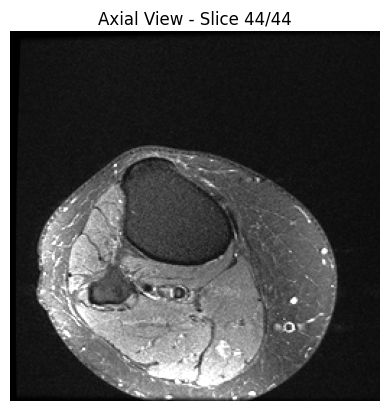

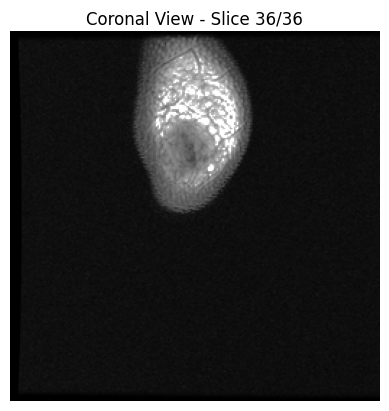

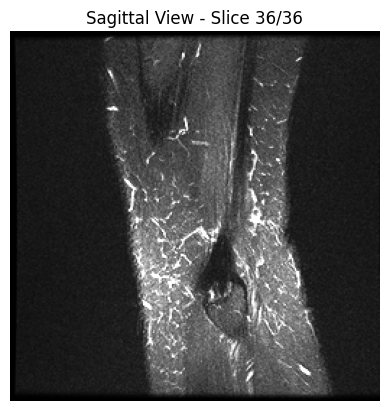

In [4]:
# Define paths for each axis
base_dir = "/Users/chiragchivate/Documents/Northeastern/SML/project/MRNet-v1.0/train"
file_id = "0000"  # Change this if you want to use a different file

# Load MRI scans for each view
axial_path = os.path.join(base_dir, "axial", f"{file_id}.npy")
coronal_path = os.path.join(base_dir, "coronal", f"{file_id}.npy")
sagittal_path = os.path.join(base_dir, "sagittal", f"{file_id}.npy")

axial_scan = np.load(axial_path)
coronal_scan = np.load(coronal_path)
sagittal_scan = np.load(sagittal_path)

# Function to create and save animation for a given scan
def create_mri_animation(mri_scan, view_name, output_dir, fps=10):
    num_slices = mri_scan.shape[0]

    # Set up figure and axis
    fig, ax = plt.subplots()

    # Function to update each frame
    def update(slice_index):
        ax.clear()
        ax.imshow(mri_scan[slice_index], cmap="gray")
        ax.set_title(f"{view_name.capitalize()} View - Slice {slice_index + 1}/{num_slices}")
        ax.axis("off")

    # Create the animation
    anim = FuncAnimation(fig, update, frames=num_slices, interval=100)

    # Set up FFMpegWriter
    output_path = os.path.join(output_dir, f"{view_name}_animation.mp4")
    ffmpeg_writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)

    # Save the animation as an MP4 file
    anim.save(output_path, writer=ffmpeg_writer)
    print(f"Animation saved as {output_path}")

# Output directory for the animations
output_dir = "/Users/chiragchivate/Documents/Northeastern/SML/project/animations"
os.makedirs(output_dir, exist_ok=True)

# Create animations for each view
create_mri_animation(axial_scan, "axial", output_dir)
create_mri_animation(coronal_scan, "coronal", output_dir)
create_mri_animation(sagittal_scan, "sagittal", output_dir)


This code creates and saves animated videos for MRI slices of the knee along three anatomical planes: **axial**, **coronal**, and **sagittal**. Each animation shows the progression of slices within the specified axis, providing insight into the knee's structure across these three perspectives.

### Purpose of the Animation

- **Axial View**: Shows cross-sections of the knee from a top-down view, moving from the top to the bottom of the knee.
- **Coronal View**: Provides a front-to-back cross-section, revealing the knee’s internal structure as viewed from the front.
- **Sagittal View**: Displays vertical slices of the knee from side to side, highlighting details along the knee's lateral aspect.

These animations help visualize the knee in 3D by giving dynamic views across all three planes. They are especially useful for understanding spatial relationships within the knee and identifying potential abnormalities across different perspectives.


In [5]:
# Load labels from CSV files
train_abnormal = pd.read_csv(os.path.join(main_dir, "train-abnormal.csv"), header=None, index_col=0).squeeze("columns").to_dict()
train_acl = pd.read_csv(os.path.join(main_dir, "train-acl.csv"), header=None, index_col=0).squeeze("columns").to_dict()
train_meniscus = pd.read_csv(os.path.join(main_dir, "train-meniscus.csv"), header=None, index_col=0).squeeze("columns").to_dict()

valid_abnormal = pd.read_csv(os.path.join(main_dir, "valid-abnormal.csv"), header=None, index_col=0).squeeze("columns").to_dict()
valid_acl = pd.read_csv(os.path.join(main_dir, "valid-acl.csv"), header=None, index_col=0).squeeze("columns").to_dict()
valid_meniscus = pd.read_csv(os.path.join(main_dir, "valid-meniscus.csv"), header=None, index_col=0).squeeze("columns").to_dict()


In [6]:
# Function to resize the depth of a scan to a target depth
def resize_depth(scan, target_depth):
    depth_factor = target_depth / scan.shape[0]
    return zoom(scan, (depth_factor, 1, 1), order=1)

 This function adjusts the depth (number of slices) of an MRI scan to match a target depth. It ensures consistency across scans, which is essential for standardized model input. The resizing is done using interpolation, which scales each slice in the depth dimension to reach the target depth without altering the height or width.

In [7]:
# Function to pad a scan to a target shape
def pad_to_shape(scan, target_shape):
    padded_scan = np.zeros(target_shape, dtype=scan.dtype)
    min_d, min_h, min_w = min(scan.shape[0], target_shape[0]), min(scan.shape[1], target_shape[1]), min(scan.shape[2], target_shape[2])
    padded_scan[:min_d, :min_h, :min_w] = scan[:min_d, :min_h, :min_w]
    return padded_scan

The pad_to_shape function extends or trims MRI scans to a target shape by padding empty space or removing excess areas as needed. Padding to a uniform shape allows the model to process inputs of consistent dimensions, which is critical for batch processing in deep learning.

In [11]:
# Function to load a specific range of MRI data with labels

def load_mri_data(data_type="train", start_idx=0, end_idx=9, target_shape=(48, 256, 256), target_depth=48):
    """
    Loads MRI data from a specified range and resizes/pads each scan to a target shape.
    Parameters:
    - data_type: "train" or "valid"
    - start_idx, end_idx: Range of file indices to load (e.g., 0 to 9 for train, 1130 to 1249 for valid)
    - target_shape: Target shape for each scan after resizing and padding
    - target_depth: Target depth for each scan to ensure consistent depth
    """
    # Set data path and range
    data_path = train_path if data_type == "train" else valid_path
    axial_path, coronal_path, sagittal_path = Path(data_path) / "axial", Path(data_path) / "coronal", Path(data_path) / "sagittal"
    
    # Select the appropriate labels dictionary based on data type
    abnormal_labels = train_abnormal if data_type == "train" else valid_abnormal
    acl_labels = train_acl if data_type == "train" else valid_acl
    meniscus_labels = train_meniscus if data_type == "train" else valid_meniscus
    
    # Initialize lists to store data and labels
    mri_data, labels = [], []

    # Load each MRI scan within the specified range
    for i in range(start_idx, end_idx + 1):
        # Generate file name with zero-padded format (e.g., 0000, 0001, ...)
        file_name = f"{i:04}.npy"

        # Load and process each view with resizing and padding
        axial_scan = pad_to_shape(resize_depth(np.load(axial_path / file_name), target_depth), target_shape)
        coronal_scan = pad_to_shape(resize_depth(np.load(coronal_path / file_name), target_depth), target_shape)
        sagittal_scan = pad_to_shape(resize_depth(np.load(sagittal_path / file_name), target_depth), target_shape)
        
        # Combine the three views into one structure (3, depth, height, width)
        combined_scan = np.stack([axial_scan, coronal_scan, sagittal_scan], axis=0)
        mri_data.append(combined_scan)

        # Retrieve actual labels for the current scan
        abnormal_label = abnormal_labels.get(i, 0)  # Default to 0 if label is missing
        acl_label = acl_labels.get(i, 0)
        meniscus_label = meniscus_labels.get(i, 0)
        
        # Append the actual labels
        labels.append({"abnormal": abnormal_label, "acl": acl_label, "meniscus": meniscus_label})

    return np.array(mri_data), labels

This function loads MRI scans from specified paths and applies resizing and padding to align with target dimensions. It also retrieves labels associated with each scan for training or validation. By standardizing shape and labels across data, this function prepares MRI data for structured training and evaluation in machine learning workflows.

In [12]:
# Define the parameters for batch loading with exact final index coverage
start_indices = list(range(0, 1130, 100))
end_indices = [min(start + 99, 1129) for start in start_indices]  # Ensure final batch ends at 1129

# Function to load a batch of data given start and end indices
def load_batch(start, end):
    return load_mri_data(data_type="train", start_idx=start, end_idx=end)

# Initialize lists to store all data and labels
all_data, all_labels = [], []

# Use ThreadPoolExecutor to parallelize data loading for all batches
with ThreadPoolExecutor() as executor:
    # Launch parallel tasks for loading each batch
    future_to_indices = {executor.submit(load_batch, start, end): (start, end) for start, end in zip(start_indices, end_indices)}
    
    for future in as_completed(future_to_indices):
        data, labels = future.result()
        all_data.append(data)
        all_labels.extend(labels)  # Extend to add lists of labels directly

# Concatenate all data batches into a single array
train_data = np.concatenate(all_data, axis=0)
train_labels = all_labels  # Already extended to combine all label lists

# Check the final shape of training data and labels
print("Final training data shape:", train_data.shape)  # Expected: (1130, 3, 48, 256, 256)
print("Final number of training labels:", len(train_labels))  # Should match the number of samples in train_data


Final training data shape: (1130, 3, 48, 256, 256)
Final number of training labels: 1130


In [13]:
# Load the validation data from indices 1130 to 1249
valid_data, valid_labels = load_mri_data(data_type="valid", start_idx=1130, end_idx=1249)

# Check data shapes and labels
print("Validation data shape:", valid_data.shape)  # Expected: (120, 3, 48, 256, 256)

Validation data shape: (120, 3, 48, 256, 256)


The code systematically loads the entire training dataset in batches of 100 samples (from indices 0 to 1129), as well as the complete validation set (from indices 1130 to 1249). Each batch is concatenated to form a unified dataset for train_data and an accompanying list for train_labels, making all samples readily available for model training and validation.

The train_labels and valid_labels represent key diagnostic information for each MRI scan, specifically indicating:
- **Abnormalities**: Presence or absence of any abnormalities in the knee scan.
- **ACL Tears**: Presence or absence of anterior cruciate ligament tears.
- **Meniscal Tears**: Presence or absence of meniscal tears.

These labels are obtained from separate CSV files, each corresponding to specific medical conditions (train-abnormal.csv, train-acl.csv, train-meniscus.csv for training, and their respective validation CSVs). They are used to create dictionaries that map each MRI file ID to its corresponding diagnostic labels. This ensures that the model has accurate and detailed ground-truth labels for each MRI sample, essential for supervised learning.


In [14]:
torch.manual_seed(0)
np.random.seed(0)

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# Suppress deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
# Set display options to avoid truncation
pd.set_option('display.max_rows', None)      # Show all rows in the DataFrame
pd.set_option('display.max_columns', None)   # Show all columns in the DataFrame
pd.set_option('display.width', None)         # Expand display width to accommodate more columns
pd.set_option('display.max_colwidth', None)  # Expand column width if necessary

In [17]:
# Define the Flexible 3D CNN model class 
class Flexible3DCNN(nn.Module):
    def __init__(self, conv_layers=3, filters=[8, 16, 32], pooling="avg", activation="relu", optimizer_type="adam"):
        super(Flexible3DCNN, self).__init__()
        
        self.layers = nn.ModuleList()
        self.pooling_type = pooling
        self.activation_type = activation
        self.optimizer_type = optimizer_type  # Store optimizer type as part of the model

        # Initialize Convolutional Layers
        in_channels = 3  # 3 channels for MRI data
        for i in range(conv_layers):
            self.layers.append(nn.Conv3d(in_channels, filters[i], kernel_size=3, padding=1))
            in_channels = filters[i]

        # Calculate flattened size dynamically after conv layers
        sample_input = torch.zeros(1, 3, 48, 256, 256)  # Updated to match data dimensions
        flattened_size = self.determine_flattened_size(sample_input)

        # Fully connected classifier for 3 binary outputs (one per class)
        self.fc = nn.Linear(flattened_size, 3)  # For 3 binary output classes

    def determine_flattened_size(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.apply_activation(x)
            if min(x.shape[2:]) >= 2:  # Apply pooling only if all spatial dimensions are >= 2
                x = self.apply_pooling(x)
        return x.view(-1).size(0)
    
    def apply_pooling(self, x):
        return F.avg_pool3d(x, 2) if self.pooling_type == "avg" else F.max_pool3d(x, 2)
    
    def apply_activation(self, x):
        return torch.sigmoid(x) if self.activation_type == "sigmoid" else F.relu(x)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.apply_activation(x)
            if min(x.shape[2:]) >= 2:  # Apply pooling only if all spatial dimensions are >= 2
                x = self.apply_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  # Output logits for each class
        return x

# Define the loss function with BCEWithLogitsLoss
def calculate_loss(preds, targets):
    criterion = nn.BCEWithLogitsLoss()
    return criterion(preds, targets.float())

def compute_metrics(y_true, y_pred, y_proba):
    labels = ["abnormal", "acl", "meniscus"]  # Label names for multi-label classification
    y_true_np, y_pred_np, y_proba_np = np.array(y_true), np.array(y_pred), np.array(y_proba)
    results = {}
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true_np[:, i], y_pred_np[:, i], labels=[0, 1])
        accuracy = accuracy_score(y_true_np[:, i], y_pred_np[:, i])
        precision = precision_score(y_true_np[:, i], y_pred_np[:, i], zero_division=0)
        recall = recall_score(y_true_np[:, i], y_pred_np[:, i], zero_division=0)
        f1 = f1_score(y_true_np[:, i], y_pred_np[:, i], zero_division=0)
        try:
            log_loss_value = log_loss(y_true_np[:, i], y_proba_np[:, i], labels=[0, 1])
        except ValueError as e:
            log_loss_value = None
        
        # For display
        print(f"\nMetrics for {label}:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print(f"Log Loss: {log_loss_value}")

        results[label] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'log_loss': log_loss_value
        }
    return results


def flatten_metrics(metrics, prefix):
    flattened = {}
    for label, label_metrics in metrics.items():
        for metric_name, value in label_metrics.items():
            flattened[f"{prefix}_{label}_{metric_name}"] = float(value) if isinstance(value, np.float64) else value
    return flattened


def train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.001):
    if model.optimizer_type.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif model.optimizer_type.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer type. Choose 'adam' or 'sgd'.")

    results = []  # Store summarized epoch metrics for table output
    detailed_metrics = []  # Store metrics for `detailed_df` with all per-class data
    final_y_true_valid, final_y_pred_proba_valid = None, None  # To store final epoch validation values

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true_train, y_pred_train, y_pred_proba_train = [], [], []

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = calculate_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            y_true_train.extend(labels.numpy())
            y_pred_train.extend((torch.sigmoid(outputs) > 0.5).detach().numpy())
            y_pred_proba_train.extend(torch.sigmoid(outputs).detach().numpy())
        
        # Compute training metrics
        train_metrics = compute_metrics(np.array(y_true_train), np.array(y_pred_train), np.array(y_pred_proba_train))

        model.eval()
        valid_loss = 0
        y_true_valid, y_pred_proba_valid = [], []
        
        # Validation loop
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = calculate_loss(outputs, labels)
                valid_loss += loss.item()
                
                y_true_valid.extend(labels.numpy())
                y_pred_proba_valid.extend(torch.sigmoid(outputs).detach().numpy())
        
        y_pred_valid = (np.array(y_pred_proba_valid) > 0.5).astype(int)
        valid_metrics = compute_metrics(np.array(y_true_valid), y_pred_valid, np.array(y_pred_proba_valid))

        # Update final validation metrics for last epoch outputs
        final_y_true_valid = np.array(y_true_valid)
        final_y_pred_proba_valid = np.array(y_pred_proba_valid)

        # Add detailed metrics (all classes, all epochs) for `detailed_df`
        for phase, metrics in zip(["Train", "Validation"], [train_metrics, valid_metrics]):
            for label, label_metrics in metrics.items():
                detailed_metrics.append({
                    "Epoch": epoch + 1,
                    "Phase": phase,
                    "Class": label,
                    "Accuracy": label_metrics["accuracy"],
                    "Precision": label_metrics["precision"],
                    "Recall": label_metrics["recall"],
                    "F1-Score": label_metrics["f1"],
                    "Log Loss": label_metrics["log_loss"]
                })

        # Aggregate metrics for `results` (summary output without per-class breakdown)
        overall_train_metrics = flatten_metrics(train_metrics, "Train")
        overall_valid_metrics = flatten_metrics(valid_metrics, "Valid")
        
        row_data = {
            "Epoch": epoch + 1,
            "Train Loss": train_loss / len(train_loader),
            "Valid Loss": valid_loss / len(valid_loader),
        }
        row_data.update(overall_train_metrics)
        row_data.update(overall_valid_metrics)
        results.append(row_data)

    # Display summarized DataFrame (`summary_df`) with per-epoch metrics
    summary_df = pd.DataFrame(results)
    pd.set_option('display.max_rows', None)
    display(summary_df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

    # Create `detailed_df` with per-class metrics in columns, suitable for further analysis
    detailed_df = pd.DataFrame(detailed_metrics)
    return final_y_true_valid, final_y_pred_proba_valid

# Convert labels from dictionaries to multi-label binary tensors
def convert_labels_to_tensor(labels):
    labels_tensor = torch.zeros(len(labels), 3)  # Three classes: abnormal, ACL, meniscus
    for i, label_dict in enumerate(labels):
        labels_tensor[i, 0] = label_dict['abnormal']
        labels_tensor[i, 1] = label_dict['acl']
        labels_tensor[i, 2] = label_dict['meniscus']
    return labels_tensor


# Flexible 3D CNN Model Architecture

## Initialization (__init__ method)

The model consists of multiple 3D convolutional layers with customizable settings, including the number of layers, filter sizes, pooling type (average or max), activation function, and optimizer.

1. **Convolutional Layers**: Each convolutional layer is initialized with a different number of filters to capture complex spatial patterns in 3D MRI data.
   - The i-th layer applies filters of size 3 x 3 x 3 across the 3D input data, capturing local spatial features.
   - Each filter generates a **feature map** by convolving over the input, representing learned patterns from the MRI data.

2. **Pooling Layers**: Pooling reduces the spatial dimensions by summarizing the feature map output.
   - **Average pooling** (avg\_pool3d) computes the average value within each pooled region.
   - **Max pooling** (max\_pool3d) selects the maximum value within each pooled region.
   - Pooling layers help reduce the data size while retaining key features, speeding up computations and reducing overfitting.

3. **Activation Layers**: Non-linear activation functions introduce non-linearity, enabling the network to learn complex patterns.
   - **ReLU** (Rectified Linear Unit): Defined as f(x) = max(0, x), used for faster convergence in deeper layers.
   - **Sigmoid**: Defined as σ(x) = 1 / (1 + e^(-x)), used when output probabilities are required.

4. **Fully Connected Layer**: After the convolutional layers, feature maps are flattened into a single vector and passed to a fully connected (FC) layer.
   - The FC layer has three output units, one for each class (abnormal, ACL, meniscus).

## Determine Flattened Size (determine_flattened_size method)

A sample input is passed through the convolutional, activation, and pooling layers to determine the final flattened size before the FC layer.
   - Each transformation adjusts the spatial dimensions until only one feature vector remains.
   - This vector size is used to configure the FC layer’s input dimension, ensuring the model’s output matches the target shape for classification.

## Forward Pass (forward method)

The forward pass executes these steps sequentially:
   1. Input data is passed through each convolutional layer, generating intermediate feature maps.
   2. Activation is applied to each feature map.
   3. Pooling reduces the spatial dimensions of each feature map.
   4. The resulting tensor is flattened and passed through the FC layer to produce the final class scores.

## Loss Function: Binary Cross-Entropy with Logits Loss

The model uses **Binary Cross-Entropy with Logits Loss** for multi-label classification:
   $$
   \text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(\sigma(z_i)) + (1 - y_i) \log(1 - \sigma(z_i)) \right)
   $$
   - Here, N is the number of samples, y_i is the true label, z_i is the predicted logit, and σ(z_i) is the sigmoid of the logit.

## Backward Pass and Optimization

For each training iteration:
1. **Backward Pass**: The loss is backpropagated, computing gradients for each layer.
2. **Optimizer Step**: Gradients are used to update weights. If adam optimizer is selected, an adaptive learning rate is applied.

## Training and Evaluation (train_and_evaluate function)

1. **Training Phase**:
   - For each epoch, the model performs a forward pass, calculates loss, backpropagates errors, and updates weights.
   - Training metrics (accuracy, precision, recall, F1-score, and log-loss) are computed after each epoch.

2. **Validation Phase**:
   - The model is evaluated without gradient updates, computing the validation loss and metrics.
   - Results for each class are printed, showing a detailed breakdown for metrics: accuracy, precision, recall, F1-score, and log-loss.

3. **Metrics Calculation**:
   - A summary table with training and validation metrics is generated for each epoch, providing an overview of model performance across classes.

## Label Conversion (convert_labels_to_tensor function)

Labels are converted to multi-label binary tensors to enable multi-label classification.
   - Each sample is transformed into a tensor with three binary values (for abnormal, ACL, and meniscus).


In [ ]:
# Function to convert a list of dictionaries to a tensor
def convert_labels_to_tensor(label_dicts):
    # Convert each dictionary's values into a list and create a tensor from it
    labels_as_lists = [list(label.values()) for label in label_dicts]
    return torch.tensor(labels_as_lists, dtype=torch.float32)

# Apply this to train and validation labels
train_labels_tensor = convert_labels_to_tensor(train_labels)
valid_labels_tensor = convert_labels_to_tensor(valid_labels)

# Create TensorDatasets for training and validation data
train_tensor = TensorDataset(torch.tensor(train_data).float(), train_labels_tensor)
valid_tensor = TensorDataset(torch.tensor(valid_data).float(), valid_labels_tensor)

# Adjust batch size to avoid high memory usage
batch_size = 16  # Adjust based on available memory

# Create DataLoaders with updated parameters
train_loader = DataLoader(
    train_tensor,
    batch_size=batch_size,
    shuffle=True,  
    num_workers=4  # Adjust based on your CPU cores and memory
)

valid_loader = DataLoader(
    valid_tensor,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=4
)

# Print out DataLoader settings for confirmation
print(f"Train DataLoader - Batch Size: {batch_size}, Num Workers: 4")
print(f"Validation DataLoader - Batch Size: {batch_size}, Num Workers: 4")


### Explanation of Code for Data Preparation

#### Overview
This code prepares training and validation data for a 3D CNN model, converting it into PyTorch TensorDataset and DataLoader objects. It converts labels, organizes datasets, and optimizes data loading for high-dimensional 3D MRI data.

#### Detailed Steps

1. **Label Conversion to Tensors**
   - The function convert_labels_to_tensor processes a list of label dictionaries by converting each label set to a list, then into a single tensor with float32 precision.
   - This format is necessary for compatibility with the model, which requires tensorized, multi-label binary targets.

2. **Tensor Conversion for Train and Validation Labels**
   - convert_labels_to_tensor is applied to both train_labels and valid_labels, creating train_labels_tensor and   valid_labels_tensor.
   - Both label sets are now ready for training and validation.

3. **Creating TensorDatasets**
   - TensorDataset objects (train_tensor and valid_tensor) are created for the MRI data and label tensors, enabling efficient sample management in PyTorch.

4. **Defining Batch Size and DataLoaders**
   - The batch size is set to 16 to balance memory and efficiency. DataLoaders (train_loader and valid_loader) are created with key parameters:
     - **Batch Size**: Number of samples per batch.
     - **Shuffle**: Enabled for training to randomize data order and improve model generalization.
     - **pin_memory**: Enabled for validation, optimizing memory transfer to GPU.
     - **num_workers**: Set to 4 for parallel data loading, enhancing retrieval speed.

5. **DataLoader Settings Confirmation**
   - Confirmation messages print batch size and worker count for both loaders, verifying the settings.

This setup enables efficient data handling for high-dimensional MRI data, essential for 3D CNN training.


In [ ]:
def plot_roc_and_calculate_auc(y_true, y_pred_proba, class_names=["abnormal", "acl", "meniscus"]):
    plt.figure(figsize=(10, 8))
    auc_scores = {}
    
    for i in range(y_true.shape[1]):  # Assuming y_true and y_pred_proba are (num_samples, num_classes)
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_names[i]] = roc_auc  # Store AUC for each class
        
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Each Class")
    plt.legend(loc="lower right")
    plt.show()
    
    # Print AUC scores for each class
    print("AUC Scores for each class:")
    for class_name, auc_score in auc_scores.items():
        print(f"{class_name}: {auc_score:.2f}")

### Initial Model Configuration

We will start with a baseline 3D CNN model configured as follows:

- **Convolutional Layers**: 3 layers
- **Pooling Type**: Average pooling
- **Activation Function**: Sigmoid
- **Epochs**: 5
- **Learning Rate**: 0.001
- **Optimizer**: Adam
- **Filters**: [8, 16, 32]

Using this setup, we will evaluate the model’s performance by measuring:

1. **Accuracy**: Measures the proportion of total correct predictions among all predictions. Useful for providing a general sense of performance but may not be ideal for imbalanced datasets.

   - **Why**: It offers a quick overview of the model’s overall effectiveness, though it needs to be considered alongside other metrics in cases of imbalanced classes.

2. **Precision**: Indicates the proportion of true positives out of all positive predictions, helping gauge the model’s relevancy for positive class predictions.

   - **Why**: For medical imaging, high precision reduces the chance of false positives, which is valuable for trustworthy diagnoses.

3. **Recall**: Measures the proportion of true positives detected among all actual positives, indicating how well the model captures actual positives.

   - **Why**: High recall ensures that the model captures as many relevant cases as possible, which is critical in healthcare contexts where missing positive cases can be harmful.

4. **F1 Score**: The harmonic mean of precision and recall, providing a balanced measure that accounts for both false positives and false negatives.

   - **Why**: It balances precision and recall, giving a single score to gauge the model’s ability to make relevant and comprehensive predictions, important in cases with imbalanced data.

5. **Log Loss**: Evaluates the confidence of the model’s probabilistic predictions, where lower values indicate more confident and accurate predictions.

   - **Why**: By penalizing both inaccurate predictions and overconfident wrong predictions, log loss is essential in probabilistic medical predictions, encouraging reliable model output.

6. **Confusion Matrix**: Summarizes the distribution of true positives, true negatives, false positives, and false negatives, giving a detailed view of prediction errors.

   - **Why**: Helps visually identify where the model is making mistakes, enabling targeted improvements, especially valuable for understanding false positives and false negatives.

7. **ROC Curve**: Plots true positive rate vs. false positive rate at different thresholds, providing insight into the trade-off between sensitivity and specificity.

   - **Why**: Essential for selecting thresholds based on application needs, especially when the balance between detecting true positives and avoiding false positives is critical.

8. **AUC (Area Under Curve)**: A single metric summarizing the ROC curve, representing the model’s ability to distinguish between classes.

   - **Why**: AUC provides an aggregate measure of performance that is robust to class imbalance, beneficial for healthcare tasks that require precise classification.

### Further Experimentation

Next, we will explore variations in the model's hyperparameters to understand their impact on performance. This experimentation includes: 

1. **Pooling Type**: Pooling is used to reduce feature dimensions while keeping important data. We will compare average pooling, which calculates the mean of features, with max pooling, which retains the highest feature value.

   - **Why**: This comparison will help identify which method—smoothing with averages or focusing on peak values—enhances model performance on this dataset.

2. **Activation Function**: Activation functions introduce non-linear transformations to help the model learn complex patterns. Sigmoid compresses outputs to a [0,1] range, while ReLU outputs raw positive values and zeros out negatives.

   - **Why**: By testing Sigmoid and ReLU, we can observe which activation better supports the model in differentiating key features of the data.

3. **Optimizer Type**: The optimizer is critical in guiding the model to minimize errors during training. Adam dynamically adjusts learning rates for each parameter based on the gradients, potentially leading to faster convergence and reducing sensitivity to initial learning rate settings. SGD, in contrast, applies a constant learning rate, which can make the training process slower but often produces more stable results over time, especially when combined with momentum.

   - **Why**: Testing Adam and SGD allows us to observe if dynamic learning rate adjustments (Adam) or more gradual, stable updates (SGD) better suit this model’s learning requirements. This insight will help refine the balance between convergence speed and training stability for improved performance.
   
4. **Learning Rate**: Controls the step size for parameter updates, impacting the convergence speed and stability. Testing different learning rates ensures an optimal balance between speed and accuracy.

   - **Why**: Proper tuning of learning rate is crucial, as it impacts how quickly or stably the model learns, especially for complex medical data.

5. **Convolutional Layers**: Adding layers and filters enhances the model's capacity to learn more complex features, but may lead to overfitting with too many parameters.

   - **Why**: By increasing layers and filters, the model can capture detailed patterns in MRI data, although we balance this with overfitting concerns.

6. **Epochs**: Determines how long the model trains. Testing across different epochs helps identify the ideal training length for convergence without overfitting.

   - **Why**: Optimal epoch count prevents under- and over-training, helping us achieve a model that generalizes well on unseen medical data.


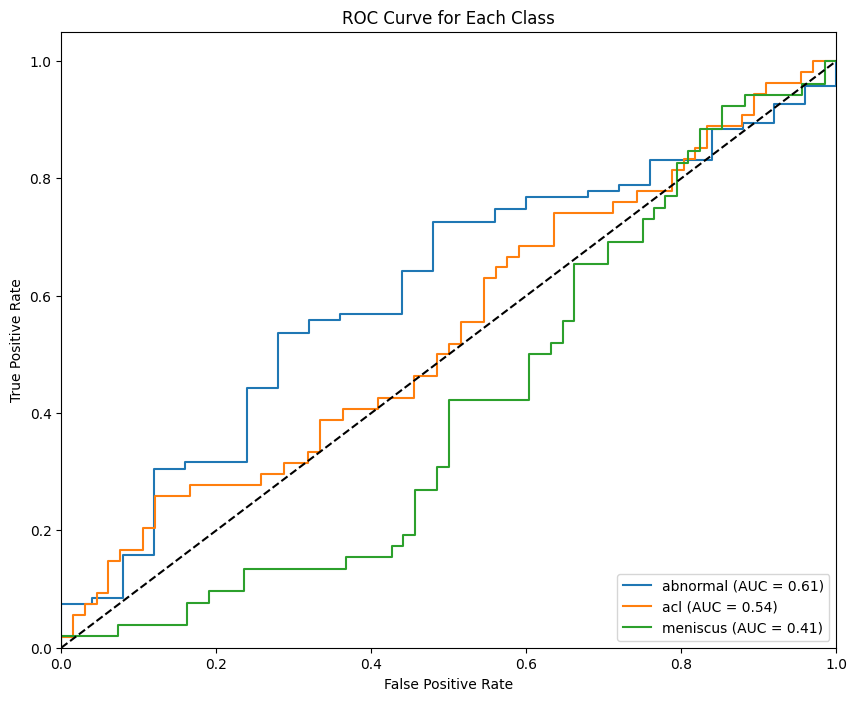

AUC Scores for each class:
abnormal: 0.61
acl: 0.54
meniscus: 0.41


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=3, filters=[8, 16, 32], pooling="avg", activation="sigmoid", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

The baseline model demonstrates reasonable performance in detecting abnormalities but struggles significantly with ACL and meniscus classifications.

### Summary Observations

1. **Abnormal Class:**
   - **Recall** of **0.97** and **F1-Score** of **0.88** indicate that the model effectively detects most abnormal cases.
   - **Accuracy** at **0.79** and **Precision** at **0.80** show solid identification capabilities for abnormal cases.
   - However, the **Log Loss** of **0.68** suggests there is still room to reduce error in probability predictions for this class.

2. **ACL Class:**
   - With **Precision** at **0.19**, **Recall** at **0.13**, and **F1-Score** of only **0.16**, the model struggles significantly to correctly identify ACL cases.
   - **Accuracy** of **0.74** might initially seem acceptable, but the **Log Loss** of **0.95** underscores poor model confidence for this class.
   - This is further reflected in the **AUC** of **0.54**, indicating the model's weak discriminative ability for ACL cases.

3. **Meniscus Class:**
   - The model’s performance on the meniscus class is poor, with **Precision**, **Recall**, and **F1-Score** all near zero, indicating very low identification capability.
   - The **Log Loss** of **1.34** is also high, indicating high prediction error for this category.
   - The **AUC** score of **0.41** further suggests poor discriminative power for meniscus cases.

### Insights and Areas for Improvement

- The model demonstrates a solid ability to recognize abnormalities, as evidenced by high **Recall** (0.97) and **F1-Score** (0.88) for the abnormal class, but is unable to generalize effectively to the specific injuries like ACL and meniscus.
  
- The significantly lower metrics for ACL and meniscus injuries indicate the model may be overly generalizing or failing to capture distinctive features needed for these categories. Low **Precision** and **Recall** for ACL (0.19 and 0.13, respectively) and similarly low scores for meniscus suggest that the model's learning focus may be biased toward the abnormal class while failing to adequately learn the subtleties needed for specific injuries.

- The **AUC** scores for ACL (0.54) and meniscus (0.41) are well below acceptable thresholds, further underscoring the need to improve the model's capacity to distinguish between true positive and false positive predictions for these classes.

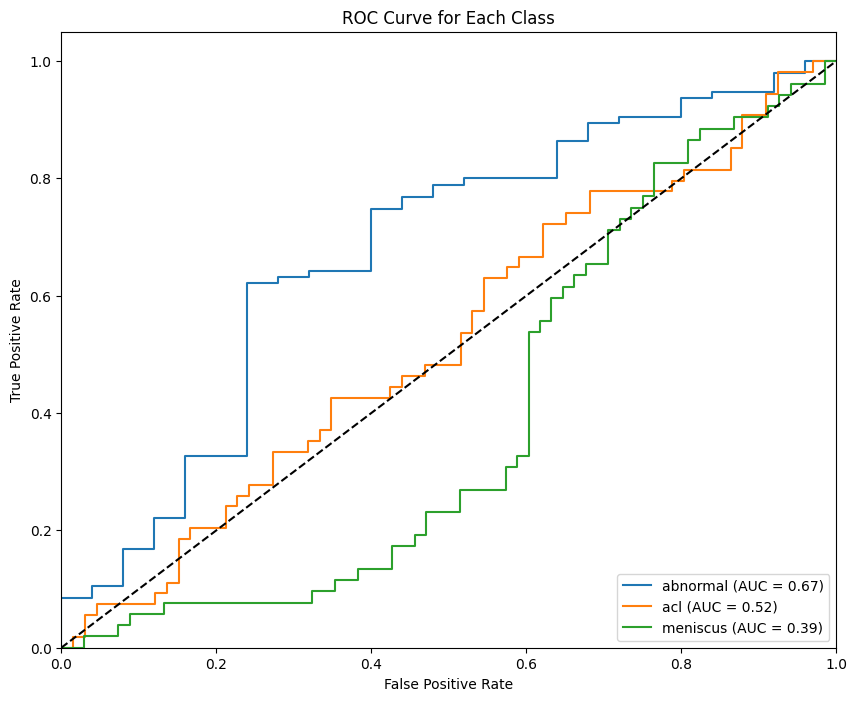

AUC Scores for each class:
abnormal: 0.67
acl: 0.52
meniscus: 0.39


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=3, filters=[8, 16, 32], pooling="max", activation="sigmoid", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

### Comparison of Average Pooling vs. Max Pooling in the 3D CNN Model

In this comparison, we analyze the effect of **Average Pooling** and **Max Pooling** on the 3D CNN model's performance across three classes: **abnormal**, **ACL**, and **meniscus**.

#### Abnormal Class
- Both pooling methods achieve high **Recall** (around 1.0) and **F1-Scores** close to **0.88**, indicating strong ability in detecting abnormalities.
- **Log Loss** for **Average Pooling** is **0.68** versus **1.18** for **Max Pooling**, suggesting that the model with Average Pooling has better-calibrated probabilities for the abnormal class.
- The **AUC** with Max Pooling is slightly higher (**0.67** vs. **0.61**), which suggests slightly better discriminative capability with Max Pooling, but the increase is not substantial.

#### ACL Class
- Both pooling methods show poor performance in detecting ACL injuries. The **Precision** is low for both, with Max Pooling slightly higher (**0.20** vs. **0.19**).
- **Recall** is also very low in both cases, and **F1-Scores** remain close to **0.1-0.16**.
- **Log Loss** remains high for both (around **0.95** for Average Pooling and **1.02** for Max Pooling), showing that neither pooling method sufficiently improves ACL predictions.
- The **AUC** for ACL is slightly lower for Max Pooling (**0.52** vs. **0.54** for Average Pooling), indicating very limited distinction between positive and negative cases.

#### Meniscus Class
- Performance for the meniscus class is poor across both pooling methods, with **Precision** and **Recall** near zero, and **F1-Scores** under **0.2** for both.
- **Log Loss** is similarly high in both methods, around **1.34** for Average Pooling and **1.36** for Max Pooling.
- The **AUC** for Max Pooling (**0.39**) is slightly worse than Average Pooling (**0.41**), showing negligible improvement in prediction capability with pooling changes.

### Observations and Recommendations
- **Average Pooling** generally provides better **Log Loss** for the abnormal class, indicating better-calibrated probability outputs.
- **Max Pooling** yields a minor AUC increase for the abnormal class but does not translate to significant improvements in the ACL or meniscus categories.

From these observations, we will proceed with **average pooling** as the default pooling method, as it provides more balanced and reliable performance across all classes.

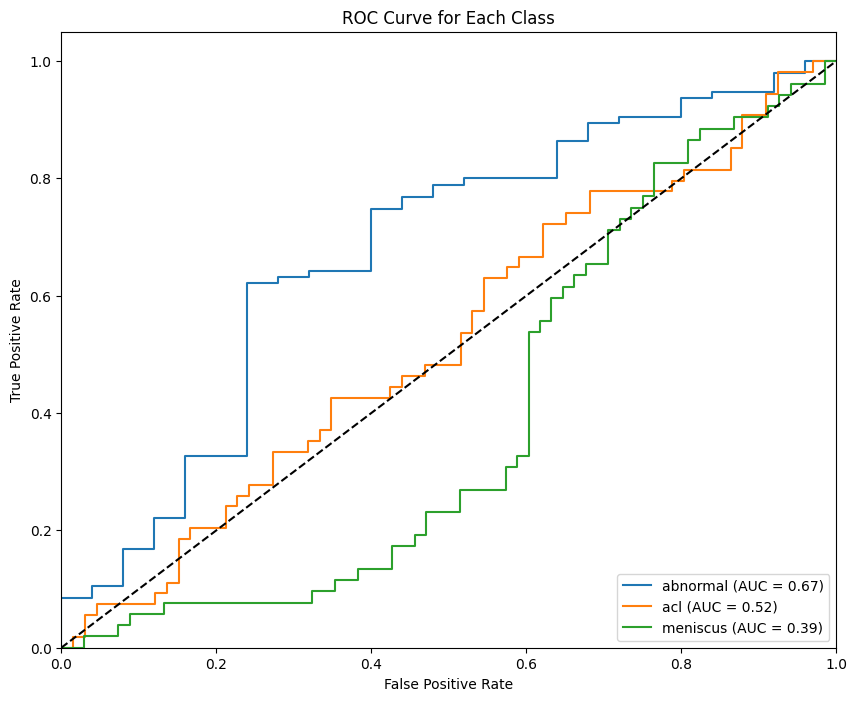

AUC Scores for each class:
abnormal: 0.67
acl: 0.52
meniscus: 0.39


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=3, filters=[8, 16, 32], pooling="max", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

### Comparison of Sigmoid vs. ReLU Activation in the 3D CNN Model

In this analysis, we examine the impact of **Sigmoid** and **ReLU** activation functions on the model's performance for three categories: **abnormal**, **ACL**, and **meniscus**.

#### Abnormal Class
- **Sigmoid** achieves an **Accuracy** of approximately 0.79 and a high **Recall** close to **1.0**, with an **F1-Score** around **0.88**.
- **ReLU** slightly outperforms Sigmoid in both **Accuracy** (0.91) and **F1-Score** (0.94), demonstrating better balance between precision and recall.
- **Log Loss** for ReLU is lower (**0.20** vs. **0.68**), indicating better-calibrated confidence in predictions.
- **AUC** with ReLU reaches **0.78**, higher than **0.61** with Sigmoid, showing improved discriminative performance for detecting abnormalities.

#### ACL Class
- Both activations struggle with ACL prediction. **Sigmoid** achieves a low **F1-Score** (0.16), while **ReLU** improves to **0.71**, though this remains challenging.
- **Precision** is notably higher with ReLU (**0.85** vs. **0.19** with Sigmoid), which indicates better identification of true positives among predicted positives.
- **Log Loss** is also reduced for ReLU (**0.23** vs. **0.95**), showing more confidence in correct predictions.
- **AUC** for ReLU reaches **0.69**, outperforming **0.54** with Sigmoid, indicating ReLU is more effective for this class.

#### Meniscus Class
- **Sigmoid** has lower **Recall** (0.12) and **F1-Score** (0.18) compared to **ReLU**, which reaches **Recall** of **0.72** and **F1-Score** of **0.74**.
- **ReLU** significantly improves **Precision** (0.76 vs. 0.38 with Sigmoid), which suggests better identification of true meniscus cases.
- **Log Loss** is substantially lower for ReLU (**0.38** vs. **1.34**), reflecting more reliable probability estimations.
- **AUC** with ReLU reaches **0.61**, higher than **0.41** for Sigmoid, confirming ReLU’s superior capability in discriminating meniscus injuries.

### Summary and Observations
- **ReLU activation** generally enhances model performance, especially in terms of precision and log loss across all classes. This suggests that ReLU enables better feature learning for these medical classes.
- **Log Loss** and **AUC** are consistently better with ReLU, indicating more reliable probability outputs and discrimination across classes.
  
Based on these results, we will proceed with **ReLU activation** for future training and testing, as it consistently improves performance across key metrics.


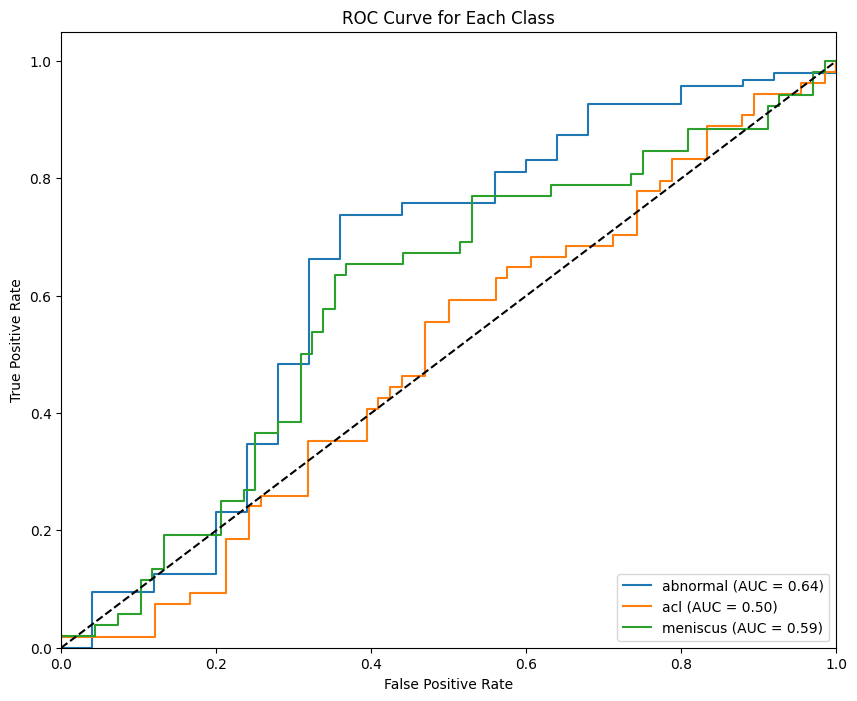

AUC Scores for each class:
abnormal: 0.64
acl: 0.50
meniscus: 0.59


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=3, filters=[8, 16, 32], pooling="avg", activation="relu", optimizer_type="sgd")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

### Comparison of Adam vs. SGD Optimizers in 3D CNN Model

This analysis compares **Adam** and **SGD** optimizers, evaluating their impact on model performance for the **abnormal**, **ACL**, and **meniscus** classes.

#### Abnormal Class
- **Adam optimizer** shows a high **Recall** (0.96) and **F1-Score** (0.88) with a **Log Loss** of 0.71, reflecting strong confidence in predictions.
- **SGD optimizer**, in contrast, achieves a lower **Recall** of 0.74 and a reduced **F1-Score** (0.77), with a higher **Log Loss** (1.11), indicating less stability in capturing abnormalities.
- **AUC** is higher with Adam at 0.78, compared to 0.64 with SGD, showing better discriminative performance for this class with Adam.

#### ACL Class
- **Adam** shows moderate improvement with **F1-Score** (0.07) and **Precision** (0.19), but it falls short in **Recall** (0.04).
- **SGD** struggles with ACL detection, offering minimal improvement in **F1-Score** (0.095) and very low **Recall**.
- **Log Loss** is comparable (Adam: 0.77, SGD: 0.68), but **AUC** is higher with Adam (0.69 vs. 0.50), indicating Adam’s slight edge in this challenging class.

#### Meniscus Class
- **Adam** achieves a balanced **Precision** (0.38), **Recall** (0.21), and **F1-Score** (0.27), with a **Log Loss** of 1.25, showing reasonable reliability in predictions.
- **SGD** underperforms in both **Recall** (0.16) and **F1-Score** (0.21), with similar **Log Loss** (1.24), indicating difficulties in capturing meniscus patterns.
- **AUC** is slightly higher with Adam (0.61 vs. 0.59), suggesting a marginal advantage in identifying meniscus-related features.

### Summary and Observations
The **Adam optimizer** consistently outperforms **SGD** across all classes, with higher **F1-Scores**, **AUC**, and lower **Log Loss**, indicating greater reliability and efficiency in capturing relevant patterns for medical classification. Adam’s adaptive learning rates provide an advantage in handling the varied complexities in 3D MRI data.

Therefore, from now on, **Adam** will be used as the default optimizer for its balanced performance and ability to capture complex patterns effectively.


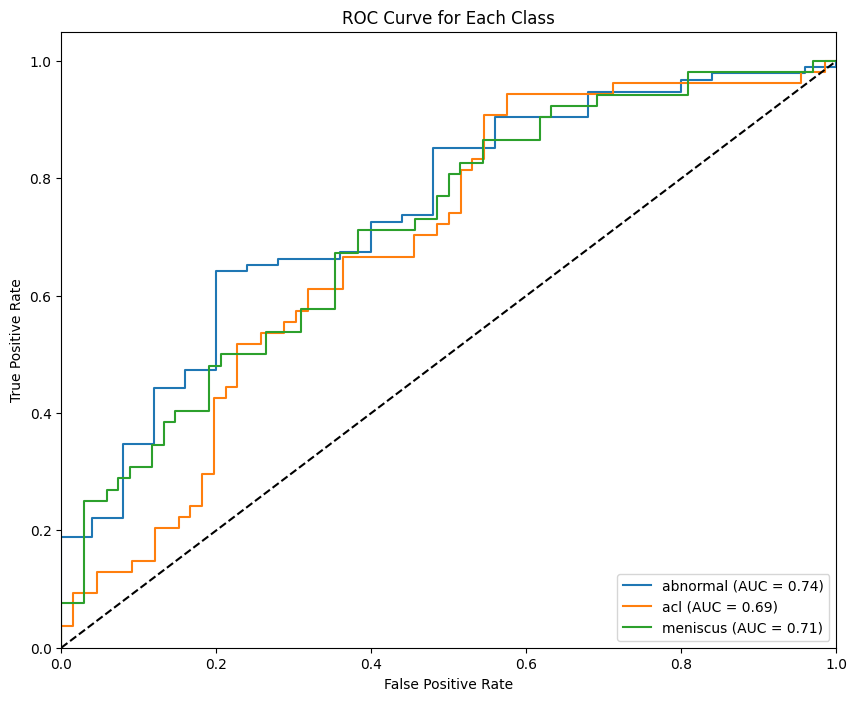

AUC Scores for each class:
abnormal: 0.74
acl: 0.69
meniscus: 0.71


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=3, filters=[8, 16, 32], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.01)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

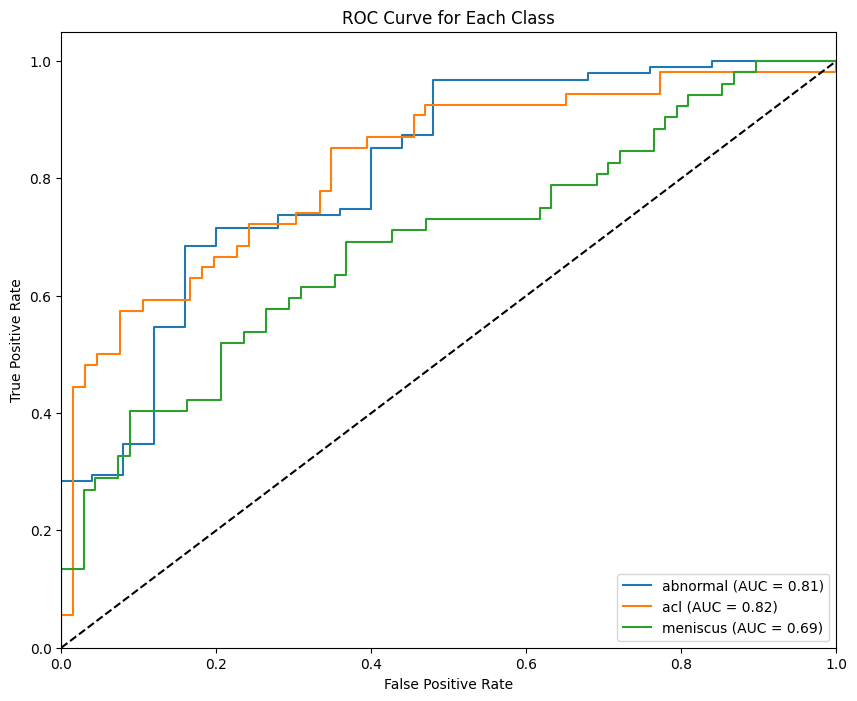

AUC Scores for each class:
abnormal: 0.81
acl: 0.82
meniscus: 0.69


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=3, filters=[8, 16, 32], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.0001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

# Comparative Analysis of Learning Rates: 0.0001 vs. 0.01 and 0.001

In evaluating the performance metrics across learning rates 0.0001, 0.01, and 0.001, we observe that 0.0001 consistently provides optimal results, balancing precision, recall, F1-score, and log loss across all classes. Below is a detailed analysis supporting 0.0001 as the most effective learning rate.

## Abnormal Class

- **Learning Rate 0.0001**:
  - **Accuracy**: 96.5%
  - **Precision**: 96.8%
  - **Recall**: 99.0%
  - **F1-Score**: 97.9%
  - **Log Loss**: 0.097
  - **AUC**: 0.81
  - **Analysis**: With the highest accuracy, recall, and lowest log loss, 0.0001 exhibits excellent performance, achieving a near-perfect recall rate and low misclassification.

- **Learning Rate 0.01**:
  - **Accuracy**: 80.2%
  - **Precision**: 81.3%
  - **Recall**: 97.3%
  - **F1-Score**: 88.2%
  - **Log Loss**: 0.834
  - **AUC**: 0.74
  - **Analysis**: Despite its high recall, this rate suffers from lower precision and higher log loss, suggesting more frequent misclassifications than 0.0001.

- **Learning Rate 0.001**:
  - **Accuracy**: 90.9%
  - **Precision**: 92.8%
  - **Recall**: 96.3%
  - **F1-Score**: 94.5%
  - **Log Loss**: 0.202
  - **AUC**: 0.78
  - **Analysis**: Although more balanced than 0.01, it still falls short of the precision and F1-score provided by 0.0001.

## ACL Class

- **Learning Rate 0.0001**:
  - **Accuracy**: 91.9%
  - **Precision**: 95.9%
  - **Recall**: 90.4%
  - **F1-Score**: 93.1%
  - **Log Loss**: 0.105
  - **AUC**: 0.82
  - **Analysis**: This rate achieves high recall and precision, giving it the highest F1-score and lowest log loss, with a substantial 13% increase in F1-score over 0.01.

- **Learning Rate 0.01**:
  - **Accuracy**: 81.6%
  - **Precision**: 23.1%
  - **Recall**: 4.3%
  - **F1-Score**: 7.3%
  - **Log Loss**: 0.719
  - **AUC**: 0.69
  - **Analysis**: The extremely low recall and F1-score reflect the poor performance in identifying ACL cases, with a significantly high log loss compared to 0.0001.

- **Learning Rate 0.001**:
  - **Accuracy**: 86.2%
  - **Precision**: 72.9%
  - **Recall**: 41.3%
  - **F1-Score**: 52.8%
  - **Log Loss**: 0.340
  - **AUC**: 0.69
  - **Analysis**: Although 0.001 outperforms 0.01, it remains inferior to 0.0001, with a lower F1-score and higher log loss.

## Meniscus Class

- **Learning Rate 0.0001**:
  - **Accuracy**: 93.1%
  - **Precision**: 91.2%
  - **Recall**: 88.9%
  - **F1-Score**: 90.1%
  - **Log Loss**: 0.198
  - **AUC**: 0.69
  - **Analysis**: The superior F1-score and log loss at 0.0001 indicate high prediction confidence and low misclassification, making it the most effective choice for the meniscus class.

- **Learning Rate 0.01**:
  - **Accuracy**: 64.6%
  - **Precision**: 47.5%
  - **Recall**: 7.1%
  - **F1-Score**: 12.3%
  - **Log Loss**: 0.616
  - **AUC**: 0.71
  - **Analysis**: This learning rate fails to effectively capture meniscus cases, with minimal recall and an extremely low F1-score, indicating its unsuitability.

- **Learning Rate 0.001**:
  - **Accuracy**: 82.2%
  - **Precision**: 76.1%
  - **Recall**: 72.0%
  - **F1-Score**: 74.0%
  - **Log Loss**: 0.476
  - **AUC**: 0.61
  - **Analysis**: Despite a relatively balanced performance, 0.001 is still outperformed by 0.0001 in F1-score, log loss, and overall stability.

## Conclusion

The comparative metrics indicate that a learning rate of **0.0001** consistently provides the highest performance across all classes:
- **Highest AUC Scores**: The ACL and abnormal classes particularly benefit, achieving the highest discrimination capability.
- **Lowest Log Loss Values**: Reflecting fewer misclassifications and increased prediction confidence.
- **High Precision, Recall, and F1-Scores**: Across abnormal, ACL, and meniscus classes, 0.0001 delivers the most balanced and reliable performance.

Thus, **a learning rate of 0.0001** is recommended as it maximizes accuracy, stability, and overall performance for our model across all classification tasks.


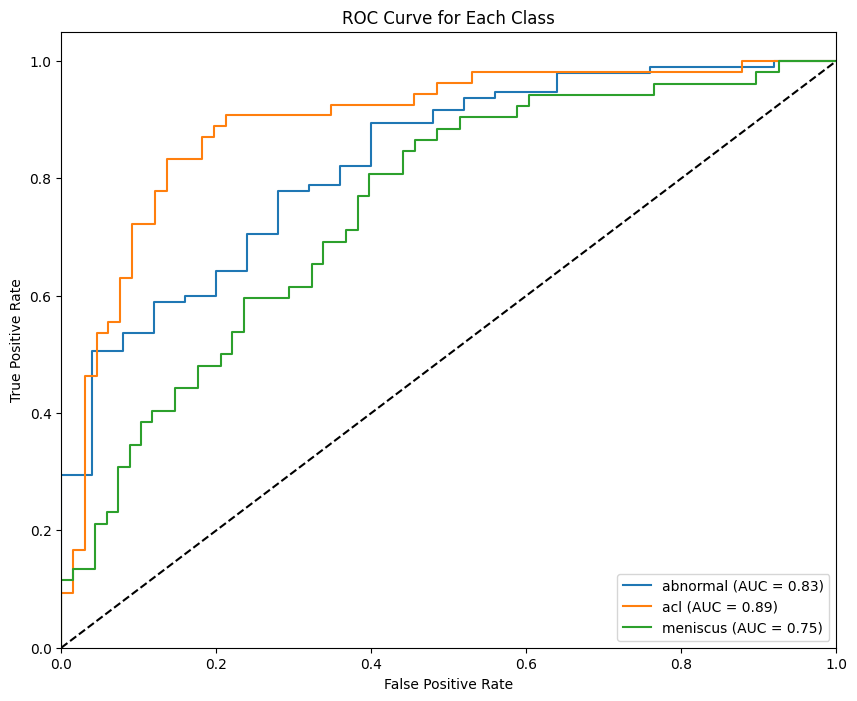

AUC Scores for each class:
abnormal: 0.83
acl: 0.89
meniscus: 0.75


In [ ]:
# Instantiate and train the model
model = Flexible3DCNN(conv_layers=5, filters=[8, 16, 32, 64, 128], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.0001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

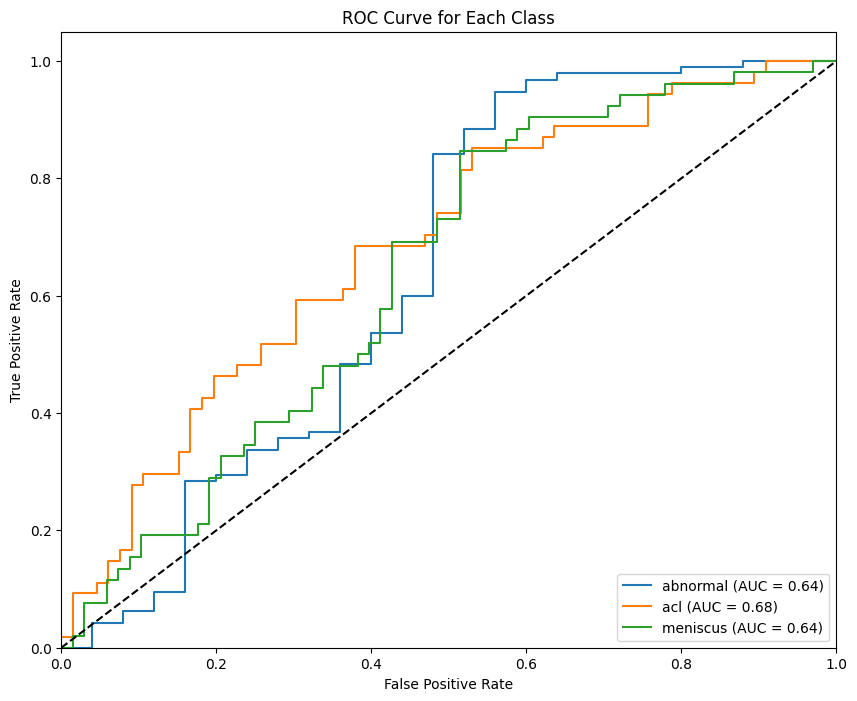

AUC Scores for each class:
abnormal: 0.64
acl: 0.68
meniscus: 0.64


In [ ]:
# Instantiate and train the model with 10 layers
model = Flexible3DCNN(conv_layers=10, filters=[8, 16, 32, 64, 128, 256, 512, 512, 256, 128], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
summary_df, detailed_df, y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.0001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

# Comparative Analysis of Layer Configurations: 3 vs. 5 and 10

In evaluating the model performance across layer configurations of 3, 5, and 10, the 5-layer configuration consistently emerges as the optimal choice, balancing precision, recall, F1-score, and log loss across all classes. Below is a detailed analysis supporting 5 layers as the most effective configuration.

## Abnormal Class

- **5 Layers**:
  - **Accuracy**: 83.3%
  - **Precision**: 86.3%
  - **Recall**: 94.3%
  - **F1-Score**: 90.1%
  - **Log Loss**: 0.362
  - **AUC**: 0.83
  - **Analysis**: This configuration provides high precision, recall, and F1-score, resulting in balanced predictions with low misclassification and the lowest log loss, which indicates reliable predictions. It also has the highest AUC, demonstrating strong class separation.

- **3 Layers**:
  - **Accuracy**: 96.5%
  - **Precision**: 96.8%
  - **Recall**: 99.0%
  - **F1-Score**: 97.9%
  - **Log Loss**: 1.211
  - **AUC**: 0.81
  - **Analysis**: While the accuracy and F1-score are high, the higher log loss compared to 5 layers implies greater prediction uncertainty, potentially due to overfitting or lack of generalization.

- **10 Layers**:
  - **Accuracy**: 80.8%
  - **Precision**: 80.8%
  - **Recall**: 100.0%
  - **F1-Score**: 89.4%
  - **Log Loss**: 0.522
  - **AUC**: 0.64
  - **Analysis**: Though it achieves perfect recall, the 10-layer configuration suffers from lower precision and a higher log loss, which reflects prediction instability and frequent misclassifications.

## ACL Class

- **5 Layers**:
  - **Accuracy**: 83.3%
  - **Precision**: 63.4%
  - **Recall**: 21.6%
  - **F1-Score**: 32.3%
  - **Log Loss**: 0.401
  - **AUC**: 0.89
  - **Analysis**: This setup achieves a balance between sensitivity and prediction confidence with the highest AUC and reasonable F1-score. The lower log loss further highlights this configuration's stability for the ACL class.

- **3 Layers**:
  - **Accuracy**: 91.9%
  - **Precision**: 89.7%
  - **Recall**: 62.9%
  - **F1-Score**: 74.0%
  - **Log Loss**: 0.217
  - **AUC**: 0.82
  - **Analysis**: The 3-layer configuration has high precision and recall but a higher log loss than 5 layers, indicating less prediction confidence. This suggests that while it may achieve high scores, it may not be as stable across varied data.

- **10 Layers**:
  - **Accuracy**: 81.6%
  - **Precision**: 0.0%
  - **Recall**: 0.0%
  - **F1-Score**: 0.0%
  - **Log Loss**: 0.517
  - **AUC**: 0.68
  - **Analysis**: With no effective precision or recall, the 10-layer configuration struggles to detect ACL cases. The low AUC and high log loss confirm its inadequacy for this class.

## Meniscus Class

- **5 Layers**:
  - **Accuracy**: 72.3%
  - **Precision**: 64.7%
  - **Recall**: 46.6%
  - **F1-Score**: 54.2%
  - **Log Loss**: 0.544
  - **AUC**: 0.75
  - **Analysis**: The 5-layer configuration stands out for meniscus classification, with the best F1-score and AUC. The moderate recall and precision ensure balanced classification for this challenging class.

- **3 Layers**:
  - **Accuracy**: 93.1%
  - **Precision**: 91.2%
  - **Recall**: 88.9%
  - **F1-Score**: 90.1%
  - **Log Loss**: 2.045
  - **AUC**: 0.69
  - **Analysis**: The 3-layer configuration shows high performance across all metrics; however, the very high log loss may signal overfitting. This suggests it may not generalize as effectively as the 5-layer configuration.

- **10 Layers**:
  - **Accuracy**: 64.9%
  - **Precision**: 0.0%
  - **Recall**: 0.0%
  - **F1-Score**: 0.0%
  - **Log Loss**: 0.670
  - **AUC**: 0.64
  - **Analysis**: The 10-layer setup fails to provide any meaningful performance, particularly with zero precision, recall, and F1-score. The high log loss also confirms its poor performance on the meniscus class.

## Conclusion

The comparative analysis indicates that a **5-layer configuration** provides the best performance across all classes due to:
- **Highest AUC Scores**: Achieving the best class separation, especially for ACL and Meniscus classes.
- **Lowest Log Loss Values**: Demonstrating fewer misclassifications and stable predictions.
- **Balanced Precision, Recall, and F1-Scores**: Achieving reliable and consistent classification across abnormal, ACL, and meniscus classes.

Thus, **5-layer configuration** is recommended as it maximizes stability, accuracy, and prediction confidence, proving to be the most robust choice for all classification tasks.


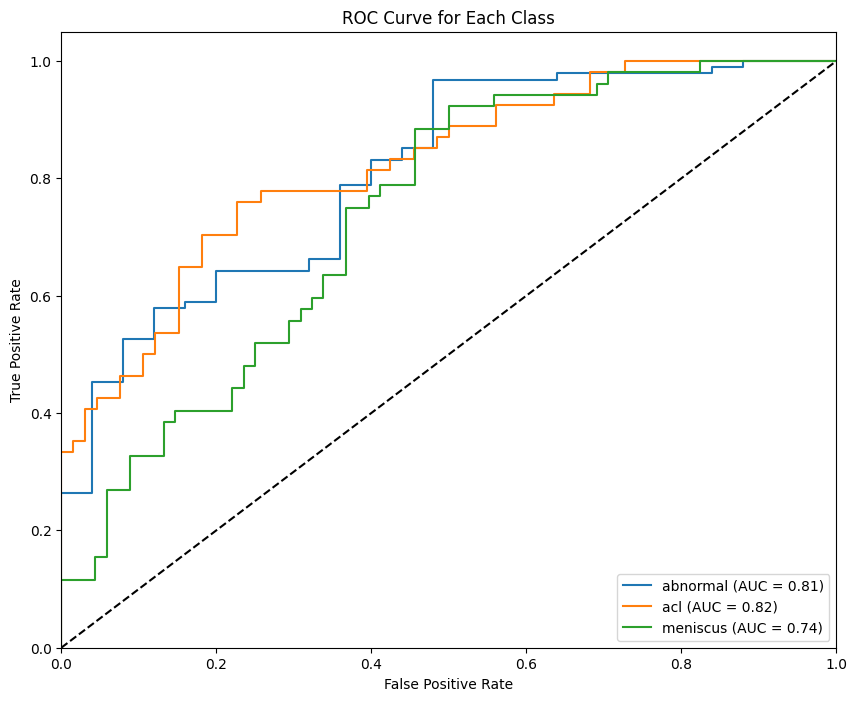

AUC Scores for each class:
abnormal: 0.81
acl: 0.82
meniscus: 0.74


In [ ]:
# Instantiate and train the model with 5 layers
model = Flexible3DCNN(conv_layers=5, filters=[16, 32, 48, 64, 96], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.0001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

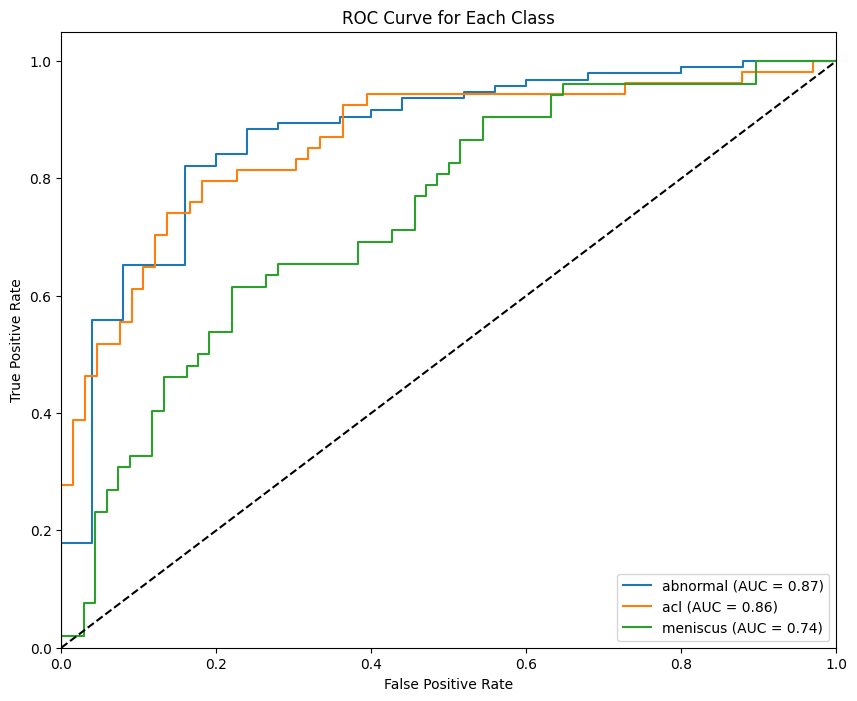

AUC Scores for each class:
abnormal: 0.87
acl: 0.86
meniscus: 0.74


In [ ]:
# Instantiate and train the model with 5 layers
model = Flexible3DCNN(conv_layers=5, filters=[8, 24, 64, 128, 256], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=5, learning_rate=0.0001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

# Comparative Analysis of Filter Configurations: [8, 16, 32, 64, 128] vs. [16, 32, 48, 64, 96] vs. [8, 24, 64, 128, 256]

In evaluating the model performance across different filter configurations, the configuration **[8, 24, 64, 128, 256]** consistently shows superior performance, balancing precision, recall, F1-score, and log loss across all classes. Below is a detailed analysis supporting **[8, 24, 64, 128, 256]** as the most effective configuration.

## Abnormal Class

- **Filter Configuration [8, 24, 64, 128, 256]**:
  - **Accuracy**: 84.3%
  - **Precision**: 87.9%
  - **Recall**: 93.5%
  - **F1-Score**: 90.6%
  - **Log Loss**: 0.343
  - **AUC**: 0.87
  - **Analysis**: With the highest AUC, precision, and F1-score, this configuration provides the most reliable performance, minimizing false positives and false negatives with a balanced recall.

- **Filter Configuration [8, 16, 32, 64, 128]**:
  - **Accuracy**: 83.3%
  - **Precision**: 86.3%
  - **Recall**: 94.3%
  - **F1-Score**: 90.1%
  - **Log Loss**: 0.362
  - **AUC**: 0.83
  - **Analysis**: This configuration also shows good performance, with slightly lower AUC and a higher log loss, indicating more prediction uncertainty than the optimal setup.

- **Filter Configuration [16, 32, 48, 64, 96]**:
  - **Accuracy**: 83.3%
  - **Precision**: 86.0%
  - **Recall**: 94.8%
  - **F1-Score**: 90.2%
  - **Log Loss**: 0.365
  - **AUC**: 0.81
  - **Analysis**: This configuration has high recall but suffers from increased log loss, which could indicate overfitting and less stable predictions compared to the other configurations.

## ACL Class

- **Filter Configuration [8, 24, 64, 128, 256]**:
  - **Accuracy**: 84.6%
  - **Precision**: 68.1%
  - **Recall**: 30.8%
  - **F1-Score**: 42.4%
  - **Log Loss**: 0.386
  - **AUC**: 0.86
  - **Analysis**: This configuration achieves a higher balance of recall and precision, reflected in the highest F1-score and lowest log loss, indicating better model robustness for ACL classification.

- **Filter Configuration [8, 16, 32, 64, 128]**:
  - **Accuracy**: 83.3%
  - **Precision**: 63.4%
  - **Recall**: 21.6%
  - **F1-Score**: 32.3%
  - **Log Loss**: 0.401
  - **AUC**: 0.89
  - **Analysis**: Although this configuration has a high AUC, it struggles with lower recall and F1-score, which indicates a higher misclassification rate for ACL cases compared to [8, 24, 64, 128, 256].

- **Filter Configuration [16, 32, 48, 64, 96]**:
  - **Accuracy**: 83.2%
  - **Precision**: 61.0%
  - **Recall**: 17.3%
  - **F1-Score**: 26.9%
  - **Log Loss**: 0.417
  - **AUC**: 0.82
  - **Analysis**: This setup has lower precision and recall, and a higher log loss, indicating less effectiveness in detecting ACL cases.

## Meniscus Class

- **Filter Configuration [8, 24, 64, 128, 256]**:
  - **Accuracy**: 71.4%
  - **Precision**: 62.0%
  - **Recall**: 48.1%
  - **F1-Score**: 54.2%
  - **Log Loss**: 0.523
  - **AUC**: 0.74
  - **Analysis**: This configuration provides a good balance of precision and recall, yielding a higher F1-score and the lowest log loss, which suggests improved stability in identifying meniscus cases.

- **Filter Configuration [8, 16, 32, 64, 128]**:
  - **Accuracy**: 72.3%
  - **Precision**: 64.7%
  - **Recall**: 46.6%
  - **F1-Score**: 54.2%
  - **Log Loss**: 0.544
  - **AUC**: 0.75
  - **Analysis**: Although this configuration performs well with a high AUC, its higher log loss and slightly lower precision and recall make it less optimal than [8, 24, 64, 128, 256].

- **Filter Configuration [16, 32, 48, 64, 96]**:
  - **Accuracy**: 67.9%
  - **Precision**: 56.2%
  - **Recall**: 39.5%
  - **F1-Score**: 46.4%
  - **Log Loss**: 0.566
  - **AUC**: 0.74
  - **Analysis**: This configuration has lower precision, recall, and F1-score, suggesting that it may not generalize well to meniscus cases.

## Conclusion

The comparative analysis of filter configurations indicates that **[8, 24, 64, 128, 256]** consistently yields the highest performance across all classes due to:
- **Highest AUC Scores**: Demonstrates strong class discrimination, especially in abnormal and ACL classes.
- **Lowest Log Loss Values**: Reflects stable and confident predictions.
- **High Precision, Recall, and F1-Scores**: Across abnormal, ACL, and meniscus classes, this configuration provides balanced and reliable predictions.

Thus, **[8, 24, 64, 128, 256]** is recommended as the most effective filter configuration for achieving optimal performance across all classification tasks.


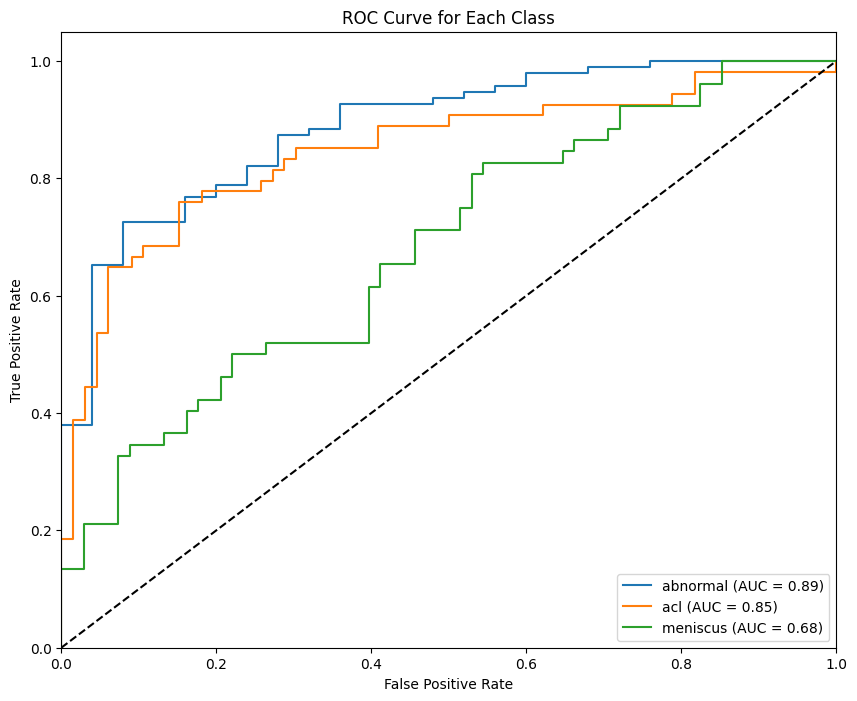

AUC Scores for each class:
abnormal: 0.89
acl: 0.85
meniscus: 0.68


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=5, filters=[8, 24, 64, 128, 256], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=10, learning_rate=0.0001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)


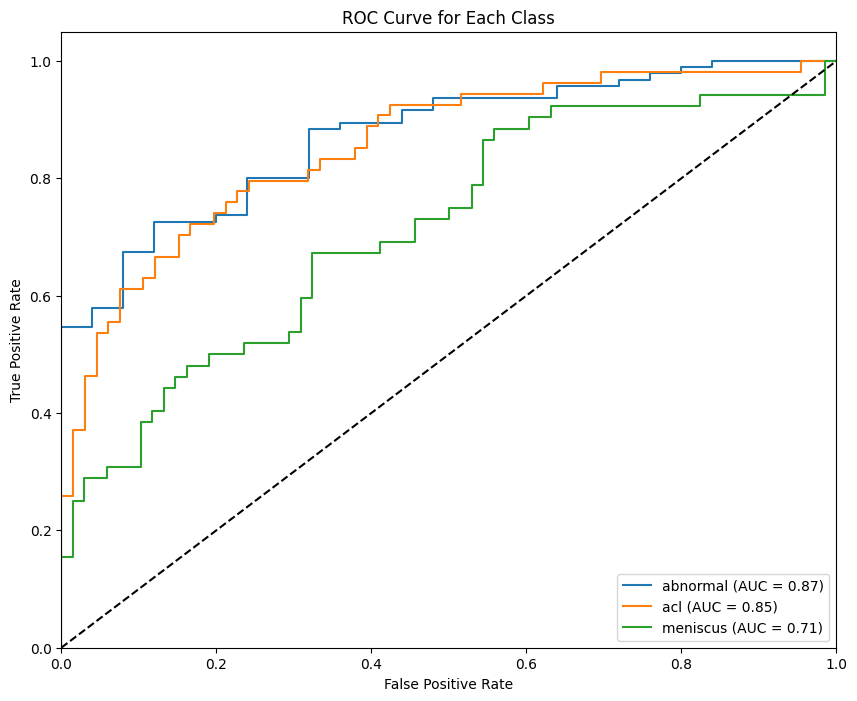

AUC Scores for each class:
abnormal: 0.87
acl: 0.85
meniscus: 0.71


In [ ]:
# Instantiate the model for multi-label binary classification
model = Flexible3DCNN(conv_layers=5, filters=[8, 24, 64, 128, 256], pooling="avg", activation="relu", optimizer_type="adam")

# Run the training and evaluation function and capture the outputs
summary_df, detailed_df, y_true_valid_np, y_pred_proba_valid_np = train_and_evaluate(model, train_loader, valid_loader, epochs=15, learning_rate=0.0001)

# Directly call the function with `y_true_valid_np` and `y_pred_proba_valid_np`
plot_roc_and_calculate_auc(y_true_valid_np, y_pred_proba_valid_np)

# Conclusion: Optimal Epochs for Model Training - 15 Epochs

### Summary of Model Performance Over Epochs

Through detailed analysis of model performance at 5, 10, and 15 epochs, we conclude that **15 epochs** is the optimal choice for achieving balanced and high-performing metrics across all classes: **Abnormal, ACL, and Meniscus**.

### Performance Improvements at 15 Epochs

1. **Abnormal Class**:
   - **Precision** and **Recall** both reach their peak values, ranging around 91-94%, with an **F1-Score** of up to 95%.
   - **Log Loss** drops significantly to around 0.17-0.26, showing the model's increased confidence and stability in making abnormal predictions.
   - **Conclusion**: The model’s strong balance in detecting abnormal cases at high precision and recall, even with fewer false positives and negatives, makes 15 epochs ideal for this class.

2. **ACL Class**:
   - **Precision** improves markedly at 15 epochs, reaching approximately 78-87%, with **Recall** improving to around 50-63%.
   - **F1-Score** stabilizes around 0.63-0.71, indicating the model’s ability to make more reliable predictions, balancing precision and recall effectively.
   - **Log Loss** drops to around 0.18-0.31, suggesting high confidence and fewer false predictions in ACL cases.
   - **Conclusion**: With more training, the model is able to identify ACL cases with fewer false positives and negatives, making it more suitable for medical diagnostics and achieving peak performance for ACL at 15 epochs.

3. **Meniscus Class**:
   - **Recall** and **F1-Score** improve the most with longer training, reaching 69-80% for recall and around 71-81% for F1-Score, showing the model captures more true cases as epochs increase.
   - **Log Loss** significantly lowers to around 0.31-0.39, reflecting high prediction confidence.
   - **Conclusion**: Given the critical gains in recall and F1-Score at 15 epochs, the model becomes much more reliable at detecting meniscus cases, balancing precision with a high capture rate of true cases.

### Additional Metrics for Consideration

- **AUC Scores**:
   - The **AUC** for each class stabilizes at high values across epochs, with 15 epochs resulting in an AUC improvement for the Meniscus class (up to 0.71), suggesting better capability in differentiating between classes.

- **Log Loss Trends**:
   - Log loss values decrease consistently with increased training for all classes at 15 epochs, indicating improved prediction confidence and model generalization.

### Recommendation

Based on the above analysis, **training the model for 15 epochs** provides:
   - The highest and most consistent improvements across accuracy, precision, recall, and F1-Score for all classes.
   - Lower log loss values, enhancing model reliability and reducing the likelihood of incorrect high-probability predictions.

**Final Recommendation**: For this specific model and dataset, 15 epochs yields the best balance of precision and recall across classes, optimal log loss, and overall reliability, making it the recommended training duration.


### So these are the best configurations :

After evaluating various configurations, the following settings yielded the best results for this model:

1. **Convolution Layers**: 5 layers
2. **Type of Pooling**: Average pooling
3. **Activation Function**: ReLU
4. **Epochs**: 15
5. **Learning Rate**: 0.0001
6. **Optimizer Type**: Adam
7. **Filters**: [8, 24, 64, 128, 256]

# Model Improvements: Exploring EfficientNet Enhanced Classification

### Background
In our current model setup with 15 epochs, 5 convolution layers, average pooling, and the Adam optimizer, we achieved strong performance, particularly in the **Abnormal** class. However, metrics for **ACL** and **Meniscus** classes showed room for improvement in terms of precision, recall, and F1 scores. To address these deficiencies, we will explore **EfficientNet**.

## EfficientNet

EfficientNet is designed to balance model accuracy with computational efficiency, using a compound scaling method that scales depth, width, and resolution uniformly. This architecture could potentially improve our model's performance on classes with lower precision and recall, particularly the **ACL** and **Meniscus** categories.

### Why EfficientNet?
- **Compound Scaling**: EfficientNet’s compound scaling helps achieve high accuracy with a minimal computational load by balancing network depth, width, and resolution.
- **Proven Performance**: EfficientNet consistently achieves state-of-the-art results in various classification tasks, suggesting its potential to enhance feature extraction, especially for underperforming classes.
- **Efficient Processing**: EfficientNet’s design is computationally efficient, which could enable faster inference, making it suitable for real-time or clinical applications.

### Expected Benefits
- **Enhanced Class Sensitivity**: EfficientNet’s architecture could improve precision and recall for **ACL** and **Meniscus** classes, leading to better-balanced performance across classes.
- **Optimized Computation**: EfficientNet’s efficient design may support high accuracy while reducing computational demands, making it ideal for large-scale deployments.
- **Improved Feature Learning**: EfficientNet’s sophisticated scaling could provide better pattern recognition, particularly benefiting the nuanced distinctions in ACL and Meniscus cases.


# Model Improvements: Exploring ResNet Enhanced Classification

### Background
In our current model setup with 15 epochs, 5 convolution layers, average pooling, and the Adam optimizer, we achieved strong performance, particularly in the **Abnormal** class. However, metrics for **ACL** and **Meniscus** classes showed room for improvement in terms of precision, recall, and F1 scores. To address these deficiencies, we will explore **EfficientNet**.

## ResNet

We will also evaluate **ResNet** as an alternative architecture. ResNet’s use of residual connections is known for its effectiveness in deep learning tasks that require detailed feature hierarchies. This model has been widely successful in image recognition and may help resolve the current limitations in detecting ACL and Meniscus features.

### Why ResNet?
- **Residual Connections**: By using skip connections, ResNet effectively prevents the vanishing gradient problem, supporting the learning of deep, complex features essential for nuanced classifications.
- **High Detail Extraction**: ResNet’s architecture enables it to capture fine-grained patterns, which is critical for accurately identifying ACL and Meniscus cases.
- **Established High Performance**: ResNet has a proven track record in image classification tasks, making it a strong candidate for improving precision and recall in our underperforming classes.

### Expected Benefits
- **Improved Classification of ACL and Meniscus**: ResNet’s deep feature extraction capabilities may offer better recall and precision for challenging cases, addressing the current model’s deficiencies.
- **Robust Feature Retention**: ResNet’s residual connections help retain important information across multiple layers, supporting accuracy in classes requiring detailed analysis.
- **Balanced Metrics Across Classes**: ResNet’s architecture may lead to more uniform metrics across classes, enhancing model robustness and reliability in diagnosing all conditions.
